<div style="text-align: right">INFO 7390 Advances in Data Sciences and Architecture </div>
<div style="text-align: right"> Suman Rawat : NUID 001058600</div>

# Assignment 3 : GAN

## Abstract
Generative Adversarial Networks, or GANs for short, are an approach to generative modeling using deep learning methods, such as convolutional neural networks.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. GANs are a clever way of training a generative model by framing the problem as a supervised learning problem with two sub-models: the generator model that we train to generate new examples, and the discriminator model that tries to classify examples as either real (from the domain) or fake (generated). The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.

GANs are an exciting and rapidly changing field, delivering on the promise of generative models in their ability to generate realistic examples across a range of problem domains, most notably in image-to-image translation tasks such as translating photos of summer to winter or day to night, and in generating photorealistic photos of objects, scenes, and people that even humans cannot tell are fake.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
import os
from re import match
from itertools import product, count, chain
from keras.utils import to_categorical
from tensorflow.keras import layers # replced keras with tensorflow.keras due to this issue 
#"AttributeError: module 'tensorflow' has no attribute 'get_default_graph"
# This occured on layers.Input()
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow as tf
from scipy.misc import imread, imshow
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dense, BatchNormalization, LeakyReLU, Input, \
                         Reshape, MaxPooling2D, Flatten, AveragePooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import glob

Using TensorFlow backend.


In [10]:
pip install scipy==1.1.0

Note: you may need to restart the kernel to use updated packages.


# Importing Images for pre processing

In [28]:
data_dir = 'C:/Users/ankur/Downloads/Kaggle Notebooks/AnimeFaces_Small/'
def load_images(data_dir):
    all_images = []
    for i, file_name in enumerate(glob.glob(data_dir + '*.png')):
        image = imread(file_name)
        all_images.append(image)
    X = np.array(all_images)
    X = (X - 127.5) / 127.5 #Normalize to -1 and 1 range
    np.random.shuffle(X)
    return X
X = load_images(data_dir)

C:\Users\ankur\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [29]:
X.shape

(8124, 64, 64, 3)

## Display first 5 images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


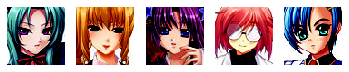

In [30]:
def show_5images(images):
    plt.figure()
    for i, image in enumerate(images):
        ax = plt.subplot(1, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
show_5images(X[20: 25])

## Function For Generators

The generator model takes a fixed-length random vector as input and generates a sample in the domain.
The vector is drawn from randomly from a Gaussian distribution, and the vector is used to seed the generative process. After training, points in this multidimensional vector space will correspond to points in the problem domain, forming a compressed representation of the data distribution.
This vector space is referred to as a latent space, or a vector space comprised of latent variables. Latent variables, or hidden variables, are those variables that are important for a domain but are not directly observable.

In [32]:
def generator():
    model = Sequential([
            Input(shape=(100, )),
            Dense(2048),
            LeakyReLU(0.2),
            
            Dense(8 * 8 * 256),
            BatchNormalization(),
            LeakyReLU(0.2),
        
            Reshape((8, 8, 256)),
            Conv2D(128, (5, 5), padding='same'),
            BatchNormalization(),
            LeakyReLU(0.2),
            
            Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
            LeakyReLU(0.2),
        
            Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
            LeakyReLU(0.2),
        
            Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
            
    ])
    return model

In [33]:
G = generator()
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         8

## Function For Discriminator

The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated).

The real example comes from the training dataset. The generated examples are output by the generator model.

The discriminator is a normal (and well understood) classification model.

After the training process, the discriminator model is discarded as we are interested in the generator.

Sometimes, the generator can be repurposed as it has learned to effectively extract features from examples in the problem domain. Some or all of the feature extraction layers can be used in transfer learning applications using the same or similar input data.

In [34]:

def discriminator():
    model = Sequential([
            Input(shape=(64, 64, 3)),
            Conv2D(64, (5, 5), padding='valid'),
            BatchNormalization(),
            LeakyReLU(0.2),
            AveragePooling2D(pool_size=(2, 2)),
        
            Conv2D(128, (3, 3), padding='valid'),
            BatchNormalization(),
            LeakyReLU(0.2),
            AveragePooling2D(pool_size=(2, 2)),
            
            Conv2D(256, (3, 3), padding='valid'),
            BatchNormalization(),
            LeakyReLU(0.2),
            AveragePooling2D(pool_size=(2, 2)),
        
            Flatten(),
            Dense(1024),
            BatchNormalization(),
            LeakyReLU(0.2),
            
            Dense(1, activation='sigmoid')
            
    ])
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

In [35]:

D = discriminator()
D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 64)        4864      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 60, 60, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

## Functions
1. sample_noise - For creating random noise which will be the intial input of generator network drawn from simple uniform distribution
2. smooth_pos_labels - For creating real label in range of 0.7 to 1.2
3. smooth_neg_labels - For creating fake label in range of 0.0 to 0.3

In [36]:
def sample_noise(batch_size, noise_dim=100):
    return np.random.normal(size=(batch_size, noise_dim))

def smooth_pos_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5) # Smooth real label to [0.7, 1.2]

def smooth_neg_labels(y):
    return y + np.random.random(y.shape) * 0.3 # Smooth fake label to [0.0, 0.3]

## Compiling GAN Models

In [37]:

def compile_gan_model(D, G, noise_dim=100):
    D.trainable = False
    gan_input = Input(shape=(noise_dim))
    gan_output = D(G(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan
gan = compile_gan_model(D, G)

In [38]:

gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 3)         35282435  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 9819009   
Total params: 45,101,444
Trainable params: 35,249,411
Non-trainable params: 9,852,033
_________________________________________________________________


In [39]:
def load_batch(X, batch_size):
    n = X.shape[0]
    n_batches = int(n / batch_size)
    for i in range(n_batches):
        yield X[i*batch_size: (i+1)*batch_size]

## Training The Model

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1]. Discriminator loss : 4.356949806213379. Generator_loss: 0.7090100049972534.


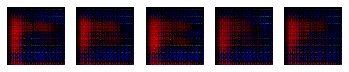

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2]. Discriminator loss : 3.880064010620117. Generator_loss: 0.682986855506897.


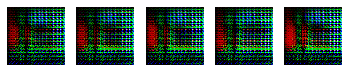

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3]. Discriminator loss : 2.856807231903076. Generator_loss: 0.6698793172836304.


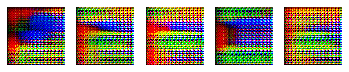

In [ ]:
def train(X, D, G, gan, epochs=100, batch_size=64):
    discriminator_loss = []
    generator_loss = []
    for i in range(1, epochs+1):
        for x in load_batch(X, batch_size):
            real_images = x
            noise = sample_noise(batch_size)
            generated_images = G.predict(noise)
            
            y_real = np.ones(batch_size)
            y_real = smooth_pos_labels(y_real)
            y_fake = np.zeros(batch_size)
            y_fake = smooth_neg_labels(y_fake)
            
            d_loss_real = D.train_on_batch(x, y_real)
            d_loss_fake = D.train_on_batch(generated_images, y_fake)
            d_loss = d_loss_real + d_loss_fake
            discriminator_loss.append(d_loss)
            
            y_real = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_real)
            generator_loss.append(g_loss)
        
        print('[Epoch {0}]. Discriminator loss : {1}. Generator_loss: {2}.'.format(i, discriminator_loss[i], generator_loss[i]))
#         plt.figure(figsize=(10, 10))
        test_noise = sample_noise(5)
        test_images = G.predict(test_noise)
        show_5images(test_images)
        plt.show()
#         for j, img in enumerate(test_images):
#             ax = plt.subplot(1, 3, j+1)
#             plt.imshow(img)
#             plt.axis('off')
#             plt.show()

train(X, D, G, gan, 150)

# Part 2 : Create a GANs generator for the same data in part A using a different kind of GAN from part A.

In [ ]:
def generator():
    model = Sequential([
            Input(shape=(100, )),
            Dense(2048),
            LeakyReLU(0.2),
            
            Dense(8 * 8 * 256),
            BatchNormalization(),
            LeakyReLU(0.2),
        
            Reshape((8, 8, 256)),
            Conv2D(128, (5, 5), padding='same'),
            BatchNormalization(),
            LeakyReLU(0.2),
            
            Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'),
            LeakyReLU(0.2),
        
            Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
            LeakyReLU(0.2),
        
            Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
            
    ])
    return model
G = generator()
G.summary()
def discriminator():
    model = Sequential([
            Input(shape=(64, 64, 3)),
            Conv2D(64, (5, 5), padding='valid'),
            BatchNormalization(),
            LeakyReLU(0.2),
            AveragePooling2D(pool_size=(2, 2)),
        
            Conv2D(128, (3, 3), padding='valid'),
            BatchNormalization(),
            LeakyReLU(0.2),
            AveragePooling2D(pool_size=(2, 2)),
            
            Conv2D(256, (3, 3), padding='valid'),
            BatchNormalization(),
            LeakyReLU(0.2),
            AveragePooling2D(pool_size=(2, 2)),
        
            Flatten(),
            Dense(1024),
            BatchNormalization(),
            LeakyReLU(0.2),
            
            Dense(1, activation='sigmoid')
            
    ])
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model
D = discriminator()
D.summary()

In [ ]:
def sample_noise(batch_size, noise_dim=100):
    return np.random.normal(size=(batch_size, noise_dim))

def smooth_pos_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5) # Smooth real label to [0.7, 1.2]

def smooth_neg_labels(y):
    return y + np.random.random(y.shape) * 0.3 # Smooth fake label to [0.0, 0.3]

def compile_gan_model(D, G, noise_dim=100):
    D.trainable = False
    gan_input = Input(shape=(noise_dim))
    gan_output = D(G(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

gan = compile_gan_model(D, G)
gan.summary()

def load_batch(X, batch_size):
    n = X.shape[0]
    n_batches = int(n / batch_size)
    for i in range(n_batches):
        yield X[i*batch_size: (i+1)*batch_size]

In [ ]:
def train(X, D, G, gan, epochs=100, batch_size=64):
    discriminator_loss = []
    generator_loss = []
    for i in range(1, epochs+1):
        for x in load_batch(X, batch_size):
            real_images = x
            noise = sample_noise(batch_size)
            generated_images = G.predict(noise)
            
            y_real = np.ones(batch_size)
            y_real = smooth_pos_labels(y_real)
            y_fake = np.zeros(batch_size)
            y_fake = smooth_neg_labels(y_fake)
            
            d_loss_real = D.train_on_batch(x, y_real)
            d_loss_fake = D.train_on_batch(generated_images, y_fake)
            d_loss = d_loss_real + d_loss_fake
            discriminator_loss.append(d_loss)
            
            y_real = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_real)
            generator_loss.append(g_loss)
        
        print('[Epoch {0}]. Discriminator loss : {1}. Generator_loss: {2}.'.format(i, discriminator_loss[i], generator_loss[i]))
#         plt.figure(figsize=(10, 10))
        test_noise = sample_noise(5)
        test_images = G.predict(test_noise)
        show_5images(test_images)
        plt.show()
#         for j, img in enumerate(test_images):
#             ax = plt.subplot(1, 3, j+1)
#             plt.imshow(img)
#             plt.axis('off')
#             plt.show()

train(X, D, G, gan, 150)

# References

1. https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
2. https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/
3. https://www.kaggle.com/nassimyagoub/gan-anime-faces
4. https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
5. https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
6. https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/

# Contribution Statement

70% of the code is used from the websites and github mentioned in refernces cell. Rest of the 40% code is written by the author using various python and reinforcement related references.

# License 
Copyright (c) 2020, Suman Rawat
All rights reserved.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.